### Note: Possibility of improvements over the choices of p(t), a0, c0

This notebook aims to showcase Ising solvers running simulated bifurcation.

References:
1. https://advances.sciencemag.org/content/5/4/eaav2372
2. https://advances.sciencemag.org/content/7/6/eabe7953

In [42]:
import numpy as np
import scipy as sp
import multiprocessing as mp
import time
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

### SB algorithms

In [3]:
def no_local(Q):
    """
    Return a matrix of shape (N+1, M+1) with no local field.
    See S1 in supplementary materials for sciadv.abe7953 for more details.
    """
    new_Q = np.zeros((Q.shape[0]+1, Q.shape[1]+1))
    new_Q[:-1, :-1] = Q - np.diag(np.diag(Q))
    new_Q[:-1, -1] = np.diag(Q)
    
    return new_Q

In [88]:
flt = np.float16

In [89]:
#@nb.njit(parallel=False)
def one_aSB_run(Q_matrix, steps, dt, Kerr_coef, a0, c0, init_y):
    """
    One (adiabatic) simulated bifurcation run over the full pump schedule.
    
    Parameters:
        Q_matrix (2-D array of float): The matrix representing the coupling field of the problem.
        steps (int): The number of iterations.
        dt (float): Time step for the discretized time.
        Kerr_coef (float): The Kerr coefficient.
        a0, c0 (float): Positive constants.
        init_y (1-D array of float): Initial y.
    
    Return: final_state (1-D array of float)
    """
    
    local_flg = False
    if np.diag(Q_matrix.todense()).any():
        Q_matrix = no_local(Q_matrix)
        local_flg = True
    
    Q_matrix = csr_matrix(Q_matrix) #turn into sparse matrix for faster matrix-vector multiplication
    
    #np.random.seed(sd)
    
    N = Q_matrix.shape[0]
    x = flt(np.zeros(N))
    y = flt(init_y)
    
    for k in range(steps):
        x += a0 * y * dt
        y -= (Kerr_coef * x**3 + a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt
        #x_history[k] = x # for analysis purposes
    
    if local_flg:
        return np.sign(x[:-1]) * np.sign(x[-1])
    else:
        return np.sign(x)

In [16]:
#@nb.njit(parallel=False)
def one_bSB_run(Q_matrix, steps, dt, a0, c0, init_y):
    """
    One ballistic simulated bifurcation run over the full pump schedule.
    
    Parameters:
        Q_matrix (2-D array of float): The matrix representing the local and coupling field of the problem.
        steps (int): The number of iterations.
        dt (float): Time step for the discretized time.
        a0, c0 (float): Positive constants.
        init_y (1-D array of float): Initial y.
    
    Return: final_state (1-D array of float)
    """
    
    local_flg = False
    if np.diag(Q_matrix.todense()).any():
        Q = no_local(Q)
        local_flg = True
    
    #np.random.seed(sd)
    
    N = Q_matrix.shape[0]
    x = flt(np.zeros(N))
    y = flt(init_y)
    
    for k in range(steps):
        x += a0 * y * dt
        y -= (a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt # pump increases from 0 to a0 linearly
        for i in range(N): # parallelizable
            if np.abs(x[i]) > 1:
                x[i] = np.sign(x[i])
                y[i] = 0
        #x_history[k] = x # for analysis purposes
    
    if local_flg:
        return np.sign(x[:-1]) * np.sign(x[-1])
    else:
        return np.sign(x)

In [40]:
#@nb.njit(parallel=False)
def one_dSB_run(Q_matrix, steps, dt, a0, c0, init_y):
    """
    One discrete simulated bifurcation run over the full pump schedule.
    
    Parameters:
        Q_matrix (2-D array of float): The matrix representing the local and coupling field of the problem.
        steps (int): The number of iterations.
        dt (float): Time step for the discretized time.
        a0, c0 (float): Positive constants.
        init_y (1-D array of float): Initial y.
    
    Return: final_state (1-D array of float)
    """
    
    #local_flg = False
    #if np.diag(Q_matrix.todense()).any():
    #    Q = no_local(Q)
    #    local_flg = True
    
    #np.random.seed(sd)
    
    N = Q_matrix.shape[0]
    x = flt(np.zeros(N))
    y = flt(init_y)
    
    for k in range(steps):
        x += a0 * y * dt
        y -= (a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(np.sign(x))) * dt
        for i in range(N): # parallelizable
            if np.abs(x[i]) > 1:
                x[i] = np.sign(x[i])
                y[i] = 0
        #x_history[k] = x # for analysis purposes
    
    return np.sign(x)
    
    #if local_flg:
    #    return np.sign(x[:-1]) * np.sign(x[-1])
    #else:
    #    return np.sign(x)

### Import problem instances
Make sure diagonal elements are all zero. SB algorithms do not work with local fields.

In [7]:
def Ising_from_maxcut_file(abs_file_path):
    """
    Import an MaxCut problem from file, and turn it into Ising form.
    
    Parameters:
        abs_file_path (str): The absolute file path for the MaxCut instance file.
    
    Return: A CSR sparse matrix in Ising form.
    """
    
    with open(abs_file_path, 'r') as f:
        coef_lst = f.read().split()
    
    return csr_matrix(([int(x) for x in coef_lst[4::3]], ([int(x)-1 for x in coef_lst[2::3]], \
                        [int(x)-1 for x in coef_lst[3::3]])), shape=(int(coef_lst[0]), int(coef_lst[0])))

### Set up subroutines

In [90]:
def cut_val(N, ins, sd, *args):
    """
    *args: (steps, dt, Kerr_coef, a0, c0)
    """
    
    abs_file_path = os.getcwd() + f"/mac_all/rudy/g05_{N}.{ins}" # absolute dir
    J = Ising_from_maxcut_file(abs_file_path)
    
    np.random.seed(sd)
    init_y = np.random.uniform(flt(-0.1), flt(0.1), J.shape[0])
    
    fin_state = one_aSB_run(J, *args, init_y)
    fin_energy = fin_state.dot(J.dot(fin_state))
    return int(0.5 * (np.sum(J) - fin_energy)) # cut value

In [91]:
def main(*args):
    for N in [60, 80, 100]:
        for ins in range(10):
            for sd in range(10):
                with open(os.getcwd()+f'/output_files/out-flt16-{args}.txt', 'a') as f:
                    f.write(f"{N} {ins} {sd} {cut_val(N, ins, sd+ins+N, *args)}\n")

In [11]:
mp.cpu_count()

144

### Benchmark on local machine

In [92]:
args_lst = [(steps, flt(dt), flt(a0), flt(c0)) for a0 in np.arange(0.5, 3.5, 0.5) for c0 in np.arange(0.1, 1.1, 0.1)]
print(len(args_lst))

pool = mp.Pool(min(mp.cpu_count(), len(args_lst))) # beware the limit of opened files in Linux

start_time = time.time()
pool_outputs = pool.starmap(main, args_lst)
total_time = time.time() - start_time

#print('ground state:\n', pool_outputs)

print(f'time: {total_time} s')

600


<ipython-input-89-500e21d91bb0>:32: RuntimeWarning: overflow encountered in power
  y -= (Kerr_coef * x**3 + a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt
<ipython-input-89-500e21d91bb0>:32: RuntimeWarning: invalid value encountered in subtract
  y -= (Kerr_coef * x**3 + a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt
<ipython-input-89-500e21d91bb0>:32: RuntimeWarning: overflow encountered in power
  y -= (Kerr_coef * x**3 + a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt
<ipython-input-89-500e21d91bb0>:32: RuntimeWarning: invalid value encountered in subtract
  y -= (Kerr_coef * x**3 + a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt
<ipython-input-89-500e21d91bb0>:32: RuntimeWarning: overflow encountered in power
  y -= (Kerr_coef * x**3 + a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt
<ipython-input-89-500e21d91bb0>:32: RuntimeWarning: invalid value encountered in subtract
  y -= (Kerr_coef * x**3 + a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt
<ipy

  File "<ipython-input-91-d083eb6b3a43>", line 6, in main
    f.write(f"{N} {ins} {sd} {cut_val(N, ins, sd+ins+N, *args)}\n")
Process ForkPoolWorker-543:
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-91-d083eb6b3a43>", line 6, in main
    f.write(f"{N} {ins} {sd} {cut_val(N, ins, sd+ins+N, *args)}\n")
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "<ipython-input-91-d083eb6b3a43>", line 6, in main
    f.write(f"{N} {ins} {sd} {cut_val(N, ins, sd+ins+N, *args)}\n")
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "<ipython-input-90-5429f02ea9b5>",

KeyboardInterrupt: 

Process ForkPoolWorker-624:
Process ForkPoolWorker-663:
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-605:
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-540:
  File "<ipython-input-90-5429f02ea9b5>", line 12, in cut_val
    fin_state = one_aSB_run(J, *args, init_y)
KeyboardInterrupt
Process ForkPoolWorker-621:
Process ForkPoolWorker-642:
Process ForkPoolWorker-640:
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-635:
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/r09222027/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*s

### See the results

In [68]:
args_lst = [(steps, flt(dt), flt(a0), flt(c0)) for a0 in np.arange(0.5, 3.5, 0.5) for c0 in np.arange(0.1, 1.1, 0.1)]

In [22]:
sol = {'60': [536, 532, 529, 538, 527, 533, 531, 535, 530, 533], \
       '80': [929, 941, 934, 923, 932, 926, 929, 929, 925, 923], \
       '100': [1430, 1425, 1432, 1424, 1440, 1436, 1434, 1431, 1432, 1430]}

In [80]:
ans_dict = {}

for args in args_lst:
    eff_rate = {'60': 0, '80': 0, '100': 0}
    with open(os.getcwd()+f'/output_files/out-dSB-{args}.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            eff_rate[line[0]] += int(line[-1]) / sol[line[0]][int(line[1])] / (len(lines)/3)
    
    ans_dict[args] = eff_rate
    print(args, eff_rate)

(10000, 0.01, 0.5, 0.1) {'60': 0.4309345643941498, '80': 0.49401699107409064, '100': 0.4700218631322477}
(10000, 0.01, 0.5, 0.2) {'60': 0.4400394583356258, '80': 0.4055226402685215, '100': 0.4379347036283838}
(10000, 0.01, 0.5, 0.3) {'60': 0.21248489363811943, '80': 0.23042688496335917, '100': 0.19429694680812187}
(10000, 0.01, 0.5, 0.4) {'60': 0.12787487260469638, '80': 0.09796766928074678, '100': 0.10161929772774701}
(10000, 0.01, 0.5, 0.5) {'60': 0.08411844292851958, '80': 0.09439858107214932, '100': 0.08640020106523986}
(10000, 0.01, 0.5, 0.6) {'60': 0.09079761741257213, '80': 0.06812087785365697, '100': 0.05615220325299625}
(10000, 0.01, 0.5, 0.7) {'60': 0.05505568283880187, '80': 0.06770001492234085, '100': 0.0547857735932705}
(10000, 0.01, 0.5, 0.8) {'60': 0.05257384503603982, '80': 0.055801841294432386, '100': 0.05650693293707135}
(10000, 0.01, 0.5, 0.9) {'60': 0.05257384503603982, '80': 0.04443035101365483, '100': 0.06351392594406434}
(10000, 0.01, 0.5, 1.0) {'60': 0.054418178

In [81]:
sorted(args_lst, key=lambda a: sum(ans_dict[a].values()), reverse=True)

[(10000, 0.01, 3.0, 0.1),
 (10000, 0.01, 1.5, 0.1),
 (10000, 0.01, 3.0, 0.2),
 (10000, 0.01, 0.5, 0.1),
 (10000, 0.01, 2.0, 0.4),
 (10000, 0.01, 3.0, 0.3),
 (10000, 0.01, 1.0, 0.9),
 (10000, 0.01, 1.0, 0.8),
 (10000, 0.01, 2.0, 0.3),
 (10000, 0.01, 0.5, 0.2),
 (10000, 0.01, 2.0, 0.5),
 (10000, 0.01, 1.0, 1.0),
 (10000, 0.01, 1.0, 0.7),
 (10000, 0.01, 1.0, 0.6),
 (10000, 0.01, 2.0, 0.2),
 (10000, 0.01, 1.0, 0.5),
 (10000, 0.01, 1.0, 0.4),
 (10000, 0.01, 2.0, 0.1),
 (10000, 0.01, 1.0, 0.3),
 (10000, 0.01, 2.0, 0.6),
 (10000, 0.01, 1.0, 0.2),
 (10000, 0.01, 1.5, 0.2),
 (10000, 0.01, 2.5, 0.2),
 (10000, 0.01, 1.0, 0.1),
 (10000, 0.01, 2.5, 0.1),
 (10000, 0.01, 3.0, 0.4),
 (10000, 0.01, 2.0, 0.7),
 (10000, 0.01, 0.5, 0.3),
 (10000, 0.01, 2.5, 1.0),
 (10000, 0.01, 2.0, 0.8),
 (10000, 0.01, 2.5, 0.9),
 (10000, 0.01, 2.5, 0.8),
 (10000, 0.01, 3.0, 0.5),
 (10000, 0.01, 2.5, 0.4),
 (10000, 0.01, 2.5, 0.7),
 (10000, 0.01, 2.5, 0.6),
 (10000, 0.01, 2.5, 0.3),
 (10000, 0.01, 2.5, 0.5),
 (10000, 0.0

In [82]:
for a in sorted(args_lst, key=lambda a: sum(ans_dict[a].values()), reverse=True):
    print(a, ans_dict[a])

(10000, 0.01, 3.0, 0.1) {'60': 0.5721284510076309, '80': 0.5251847933424373, '100': 0.5079412565988544}
(10000, 0.01, 1.5, 0.1) {'60': 0.5645841926369375, '80': 0.5091476291549372, '100': 0.5276124640956507}
(10000, 0.01, 3.0, 0.2) {'60': 0.4819734447399035, '80': 0.4939861671724836, '100': 0.43948043516155255}
(10000, 0.01, 0.5, 0.1) {'60': 0.4309345643941498, '80': 0.49401699107409064, '100': 0.4700218631322477}
(10000, 0.01, 2.0, 0.4) {'60': 0.49779796178019514, '80': 0.437010627942455, '100': 0.4116733842787262}
(10000, 0.01, 3.0, 0.3) {'60': 0.4662294546051524, '80': 0.41684730277491405, '100': 0.45404398683634084}
(10000, 0.01, 1.0, 0.9) {'60': 0.4583929170709325, '80': 0.4401915921105548, '100': 0.4286598747433712}
(10000, 0.01, 1.0, 0.8) {'60': 0.4906495893053059, '80': 0.41898166651932317, '100': 0.4022633965592407}
(10000, 0.01, 2.0, 0.3) {'60': 0.42646789080143666, '80': 0.42717962900888673, '100': 0.4412942892057673}
(10000, 0.01, 0.5, 0.2) {'60': 0.4400394583356258, '80': 

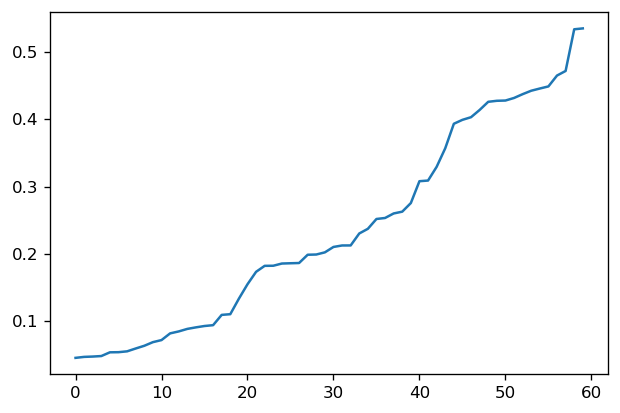

In [83]:
fig = plt.figure(dpi=120)
ax = plt.axes()
y = [sum(ans_dict[b].values())/3 for b in sorted(args_lst, key=lambda a: sum(ans_dict[a].values()))]

ax.plot(np.arange(len(y)), y)

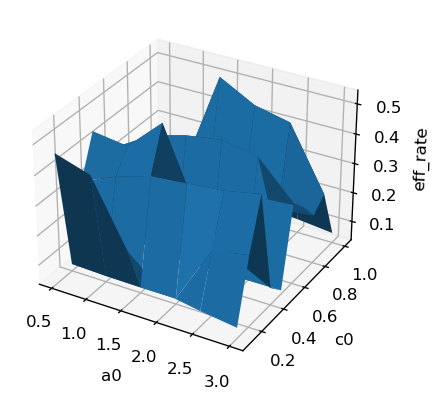

In [87]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection='3d')
a = np.arange(0.5, 3.5, 0.5)
c = np.arange(0.1, 1.1, 0.1)
X, Y = np.meshgrid(a, c)
zs = np.array([sum(ans_dict[b].values())/3 for b in args_lst])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('a0')
ax.set_ylabel('c0')
ax.set_zlabel('eff_rate')

plt.show()

In [34]:
np.__version__

'1.19.2'

In [35]:
sp.__version__

'1.6.2'

In [36]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'